### Requirements
* `pip install pandas`
* `pip install numpy`
* `pip install pyvis`
* `pip install networkx`
* `pip install nltk`
* `pip install scikit-learn`

In [1]:
from itertools import combinations
from pyvis.network import Network
import networkx as nx
import numpy as np
import pandas as pd
import json
import copy
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calummacdonald/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/calummacdonald/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data

For the hackathon, we have provided extracts of three types of "entity" data we store on the HDRUK gateway:
* **datasets** - metadata about healthdata datasets
* **publications** - healthdata publications
* **tools** - analysis scripts, software packages, various other software based tools

Load them up from the provided json files:

In [2]:
datasets = []
publications = []
tools = []
with open ('./data/datasets.json') as f:
    datasets = json.load(f)
with open ('./data/publications.json') as f:
    publications = json.load(f)
with open ('./data/tools.json') as f:
    tools = json.load(f)

len(datasets), len(publications), len(tools)

(1059, 3199, 243)

#### Example dataset

In [3]:
print (json.dumps(datasets[10],indent=6))

{
      "id": 11,
      "metadata": {
            "observations": [
                  {
                        "measuredValue": 1,
                        "measuredProperty": "Count",
                        "observationDate": "2021-06-16",
                        "disambiguatingDescription": "Count of completed (processed) COVID-19 antigen tests carried out in NHS hospitals in Northern Ireland",
                        "observedNode": "Events"
                  }
            ],
            "omics": null,
            "tissuesSampleCollection": [],
            "structuralMetadata": [],
            "coverage": {
                  "followUp": "Unknown",
                  "datasetCompleteness": null,
                  "typicalAgeRange": "0-150",
                  "pathway": "Dataset relates to a single type of antigen testing",
                  "spatial": "United Kingdom,Northern Ireland"
            },
            "summary": {
                  "description": "This dataset is extracted 

This metadata conforms to the HDRUK standard Gateway Data Model (GWDM) version `2.0`

To understand the meeting of the different fields in our schema, you can use our [HDR schemata](https://hdruk.github.io/schemata-2/GWDM/2.0/) documentation 

#### Example publication

In [4]:
print (json.dumps(publications[0],indent=6))

{
      "publication_type": "Research articles",
      "paper_title": "The role of health and social factors in education outcome: A record-linked electronic birth cohort analysis.",
      "id": 1,
      "year_of_publication": "2019",
      "journal_name": "PloS one",
      "authors": "Evans A, Dunstan F, Fone DL, Bandyopadhyay A, Schofield B, Demmler JC, Rahman MA, Lyons RA, Paranjothy S.",
      "paper_doi": "https://doi.org/10.1371/journal.pone.0220771",
      "abstract": "<h4>Background and objective</h4>Health status in childhood is correlated with educational outcomes. Emergency hospital admissions during childhood are common but it is not known how these unplanned breaks from schooling impact on education outcomes. We hypothesised that children who had emergency hospital admissions had an increased risk of lower educational attainment, in addition to the increased risks associated with other health, social and school factors.<h4>Methods</h4>This record-linked electronic birth co

#### Example Tool

In [5]:
print (json.dumps(tools[0],indent=6))

{
      "name": "Test Tool",
      "id": 1,
      "description": "This is a test",
      "tech_stack": null,
      "programming_languages": [],
      "type_category": [],
      "publications": [],
      "url": "https://example.com",
      "results_insights": null,
      "category": {
            "updated_at": "2024-10-08T11:35:24.000000Z",
            "enabled": true,
            "id": 6,
            "created_at": "2024-10-08T11:35:24.000000Z",
            "name": "Code snippet"
      },
      "tag": [],
      "license": {
            "updated_at": "2024-10-08T11:03:09.000000Z",
            "origin": "HDR",
            "valid_until": null,
            "label": "Available upon request",
            "created_at": "2024-10-08T11:03:09.000000Z",
            "definition": "Access to the software/code/tool is made available via a request and approval mechanism. The entity posting the entry can provide more information on access limitations or use.",
            "valid_since": "2024-04-15 00:

#### Linkages

We have also provided (in JSON) linakges that we have already curated for:

* **datasets <--> datasets**
* **datasets <--> publications**
* **datasets <--> tools**
* **publications <--> tools** 

These are given as links between a __source__ and a __target__, each entity (dataset, publication, tool) has a `id` that these refer to

In [6]:
dataset_to_dataset = pd.read_json("./data/linkages_dataset_to_dataset.json").set_index('source_dataset_id')
dataset_to_dataset

,target_dataset_id
source_dataset_id,
16,20
19,20
31,15
51,78
54,700
...,...
719,722
809,808
811,808


In [7]:
dataset_to_publication = pd.read_json("./data/linkages_dataset_to_publication.json").set_index('source_dataset_id')
dataset_to_publication

,target_publication_id
source_dataset_id,
11,1411
14,523
14,1537
14,1664
15,1406
...,...
880,2386
880,3015
881,2343


In [8]:
dataset_to_tool = pd.read_json("./data/linkages_dataset_to_tool.json").set_index('source_dataset_id')
dataset_to_tool.head(5)

,target_tool_id
source_dataset_id,
778,93
23,102
283,102
413,102
728,102


In [9]:
tool_to_publication = pd.read_json("./data/linkages_tool_to_publication.json").set_index('source_tool_id')
tool_to_publication

,target_publication_id
source_tool_id,
234,296
242,3166
243,3166


### Building a Simple Network Graph

Given the data we have provided, we can build a simple network graph to visualise the existing entities and linkages between them:

First, add all datasets as nodes...

In [10]:
G = nx.Graph()

for entry in datasets:
    node_id = f"dataset_{entry['id']}"
    short_title = entry.get('metadata', {}).get('summary', {}).get('shortTitle', f"Dataset {node_id}")
    G.add_node(node_id, title=short_title, label=short_title, group=1)

len(G.nodes)

1044

Add linkages as edges...

In [11]:
for _, row in dataset_to_dataset.iterrows():
    source = f"dataset_{row.name}"
    target = f"dataset_{row['target_dataset_id']}"
    G.add_edge(source, target, group=1)

Add publications and linkages between them and datasets

In [12]:
for entry in publications:
    node_id = f"publication_{entry['id']}"
    if (doi := entry.get('paper_doi',None)):
        doi = doi.replace("https://doi.org/","")
        G.add_node(node_id, title=doi, label=doi, group=2)

for _, row in dataset_to_publication.iterrows():
    source = f"dataset_{row.name}"
    target = f"publication_{row['target_publication_id']}"
    G.add_edge(source, target, group=2)

len(G.nodes)

4242

Do the same for tools...

In [13]:
for entry in tools:
    node_id = f"tool_{entry['id']}"
    if (name := entry.get('name',None)):
        G.add_node(node_id, title=name, label=name, group=3)

for _, row in dataset_to_tool.iterrows():
    source = f"dataset_{row.name}"
    target = f"tool_{row['target_tool_id']}"
    G.add_edge(source, target, group=3)

for _, row in tool_to_publication.iterrows():
    source = f"tool_{row.name}"
    target = f"publication_{row['target_publication_id']}"
    G.add_edge(source, target, group=3)

len(G.nodes)

4485

Make a copy of the graph with all entity nodes

In [14]:
Gorig = copy.deepcopy(G) 

Remove isolated nodes - in the gateway we have a lot of entities that have no linkages (yet!)

In [15]:
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
len(G.nodes)

801

Draw a visualisation of this graph

In [16]:
net = Network(notebook=True)
net.from_nx(G)

net.barnes_hut(
    gravity=-2000,
    central_gravity=0.3,
    spring_length=95,
    spring_strength=0.04,
    damping=0.09,
    overlap=0.1
)

net.show("./public/direct_orginal_linkages.html")

./public/direct_orginal_linkages.html


### Finding additional linkages

Now we can explore trying to build up more indirect linkages

Firstly, in a simple example, we can extract all authors from the publications 

In [17]:
publication_authors = [
    set([
        auth.lstrip()
        for auth in 
        pub["authors"].split(",")
    ]) 
    for pub in publications
]
publication_authors[0]

{'Bandyopadhyay A',
 'Demmler JC',
 'Dunstan F',
 'Evans A',
 'Fone DL',
 'Lyons RA',
 'Paranjothy S.',
 'Rahman MA',
 'Schofield B'}

Build a similarity matrix based on how many overlapping authors two papers have..

In [18]:
n = len(publication_authors)
similarity_matrix = np.zeros((n, n))

for i, j in combinations(range(n), 2):
    common_authors = publication_authors[i] & publication_authors[j]  
    min_authors = min(len(publication_authors[i]), len(publication_authors[j])) 
    similarity_matrix[i, j] = similarity_matrix[j, i] = len(common_authors) / min_authors if min_authors > 0 else 0

similarity_matrix = np.tril(similarity_matrix)
np.fill_diagonal(similarity_matrix, 0)
    
similarity_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.1875    , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07692308, 0.        , ..., 0.15384615, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Find those publications in which there is a >80% overlap in the authors

In [19]:
high_similarity_indices = np.argwhere((similarity_matrix >= 0.8))

For example...

In [20]:
similar = high_similarity_indices[10]
similar

array([160,  35])

In [21]:
publications[similar[0]]['authors']

'Patel H, Dobson RJB, Newhouse SJ.'

In [22]:
publications[similar[1]]['authors']

'Patel H, Iniesta R, Stahl D, Dobson RJB, Newhouse SJ.'

Now add these assumed linkaged from authorship overlap as an additional linkage between publications

In [23]:
G2 = copy.deepcopy(Gorig)
for i,j in high_similarity_indices:
    source = f"publication_{publications[i]['id']}"
    target = f"publication_{publications[j]['id']}"    
    G2.add_edge(source, target, group=4)

isolated_nodes = list(nx.isolates(G2))
G2.remove_nodes_from(isolated_nodes)
len(G.nodes)

801

Draw the new graph with these added relationships

In [24]:
net = Network(notebook=True)
net.from_nx(G2)

net.barnes_hut(
    gravity=-2000,
    central_gravity=0.3,
    spring_length=95,
    spring_strength=0.04,
    damping=0.09,
    overlap=0.1
)
net.show("./public/direct_linkages_with_authors.html")

./public/direct_linkages_with_authors.html


#### Additional dataset linkages

The dataset metadata contains an abstract about the datasets - we can use this and some simple NLP to try and extract some indirect linkages

For example, an abstract may look like this:

In [25]:
datasets[0]['metadata']['summary']['abstract']

'The UK Cystic Fibrosis Registry Culture is made up of many data items relating to microbiology and cultures grown from samples taken during CF patient encounters at NHS hospitals in UK.'

Extract the abstracts:

In [26]:
dataset_abstracts = [
    dataset['metadata']['summary']["abstract"] 
    if dataset['metadata']['summary']["abstract"] 
    else "" 
    for dataset in datasets
]

Tokenise the words in the abstracts

In [27]:
tokenized_abstracts = [
    " ".join(word_tokenize(abstract.lower())) 
    for abstract in dataset_abstracts
]

Vectorise and calcuated a simularity matrix between all the dataset abstracts

In [28]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  
tfidf_matrix = vectorizer.fit_transform(tokenized_abstracts)

similarity_matrix = np.tril(cosine_similarity(tfidf_matrix))
np.fill_diagonal(similarity_matrix, 0)
similarity_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.58587943, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.34776338, 0.32731339, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00748172, 0.0068858 , 0.00593754, ..., 0.        , 0.        ,
        0.        ],
       [0.0707266 , 0.06509324, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04141645, 0.03811764, 0.        , ..., 0.        , 0.09169122,
        0.        ]])

In [29]:
similarity_matrix.shape,len(datasets)

((1059, 1059), 1059)

Find some examples of high overlap in the abstracts:

In [30]:
high_similarity_indices = np.argwhere((similarity_matrix >= 0.75) & (similarity_matrix < 0.98))
similar = high_similarity_indices[12]
similar

array([165, 163])

In [31]:
similarity_matrix[similar[0],similar[1]]

np.float64(0.7874033102505323)

In [32]:
dataset_abstracts[similar[0]]

'Chronic Obstructive Pulmonary Disease (COPD) patients admitted or using hospital services. Granular care pathways. Multi-morbidity, investigations, interventions, treatments. Serial physiology, blood biomarkers, physiotherapy, outcome. Deeply phenotyped.'

In [33]:
dataset_abstracts[similar[1]]

'Patients admitted with a COPD related event. Granular care pathways. Multi-morbidity, investigations, interventions and treatments.   Serial physiology, blood biomarkers, physiotherapy, outcome. Deeply phenotyped.'

Construct a third network graph, to add in these additional indirect linkages based on the abstracts..

In [38]:
G3 = copy.deepcopy(G2)

In [39]:
for i,j in high_similarity_indices:
    source = f"dataset_{datasets[i]['id']}"
    target = f"dataset_{datasets[j]['id']}"
    G3.add_edge(source, target, color='red', weight=0.5)

isolated_nodes = list(nx.isolates(G3))
G3.remove_nodes_from(isolated_nodes)
len(G3.nodes)

2041

In [ ]:
for i,j in high_similarity_indices:
    source = f"dataset_{datasets[i]['id']}"
    target = f"dataset_{datasets[j]['id']}"
    G3.add_edge(source, target, color='red')

isolated_nodes = list(nx.isolates(G3))
G3.remove_nodes_from(isolated_nodes)
len(G3.nodes)

In [37]:
net = Network(notebook=True)
net.from_nx(G3)

net.barnes_hut(
    gravity=-2000,
    central_gravity=0.3,
    spring_length=95,
    spring_strength=0.04,
    damping=0.09,
    overlap=0.1
)
net.show("./public/direct_linkages_and_indirect.html")

./public/direct_linkages_and_indirect.html


Visualise in a "simpler" manner... 

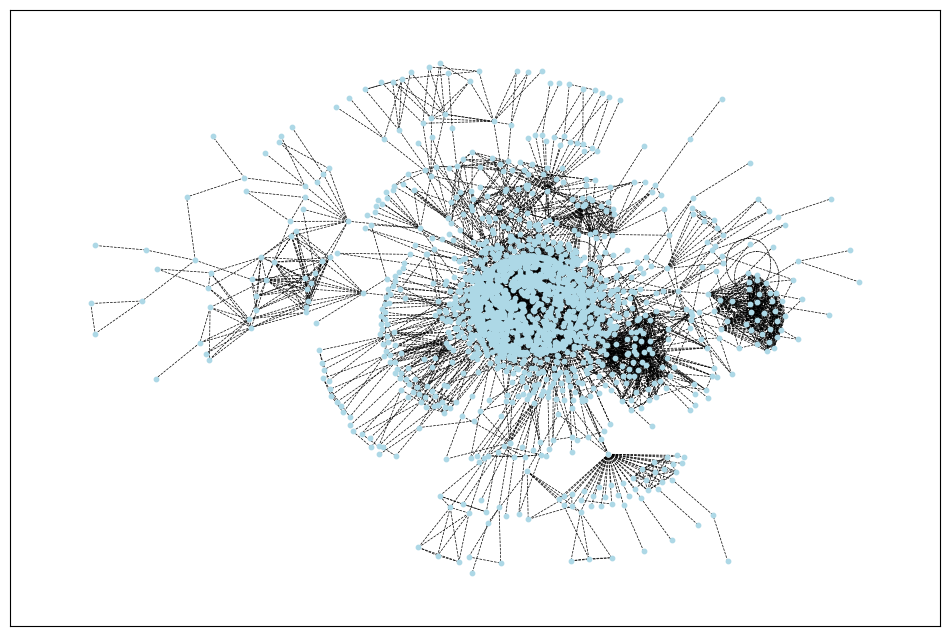

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))  
pos = nx.kamada_kawai_layout(G3) 

nx.draw_networkx_nodes(G3, pos, node_size=10, node_color='lightblue')

edges = G3.edges()
edge_colors = ['black' for _ in edges]
edge_styles = ['--' for _ in edges]
nx.draw_networkx_edges(G3, pos, edgelist=edges, edge_color=edge_colors, style='--', width=0.5)


plt.show()